<a href="https://colab.research.google.com/github/enjoyPG/2023Gifted/blob/main/students/jwoo428/%ED%85%90%EC%B4%8815%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이터없이 학습하는 GAN

##핵심용어


*   모델 경량화는 가중치 개수가 많은 교사 모델의 출력과, 가중치 개수가 적은 학생모델의 출력이 비슷해지도록 학습하는것
*   지식증류 알고리즘은 가중치가 많은 교사 모델을 이용해 가중치가 적은 학생모델을 학습시키는 알고리즘

*   모델 경량화와 gan을 이용하면 데이터 없이도 학생모델을 학습할 수 있습니다.


*   데이터 없이 학습할 때는 생성자보다 학생모델을 더 많이 학습합니다.


*   L1손실은 두 값의 차이의 절댓값을 의미합니다. L2손실은 MSE처럼 두값의 차이를 제곱함



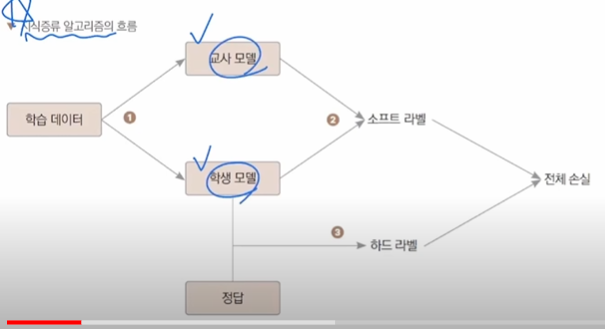

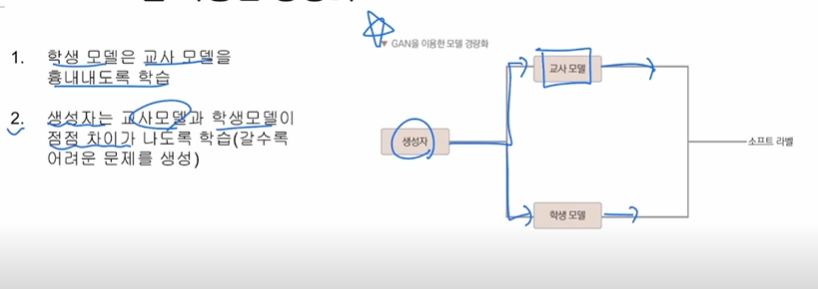

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 전처리 정의

In [2]:
import tqdm
import torch
import torch.nn as nn

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torchvision.transforms import Normalize
from torch.utils.data.dataloader import DataLoader
from torchvision.models.resnet import resnet34, resnet18


from torch.optim.adam import Adam

# 학습할 때 이용할 전처리 정의
transforms = Compose([
   RandomCrop((32, 32), padding=4),
   RandomHorizontalFlip(p=0.5),
   ToTensor(),
   Normalize(mean=(0.4914, 0.4822, 0.4465),
             std=(0.247, 0.243, 0.261))
])

# 교사모델 학습에 필요한 요소 정의

In [3]:
# 학습용 데이터 준비
training_data = CIFAR10(root="./",
                        train=True,
                        download=True,
                        transform=transforms)
test_data = CIFAR10(root="./",
                    train=False,
                    download=True,
                    transform=transforms)

# 검증용 데이터 준비
train_loader = DataLoader(
    training_data,
    batch_size=32,
    shuffle=True)
test_loader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

# 교사 모델 정의
teacher = resnet34(pretrained=False, num_classes=10)
teacher.to(device)

lr = 1e-5
optim = Adam(teacher.parameters(), lr=lr)

100%|██████████| 170498071/170498071 [00:02<00:00, 71724378.28it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# 교사모델 학습 루프 정의

In [4]:
# 학습 루프
for epoch in range(30):
   iterator = tqdm.tqdm(train_loader)
   for data, label in iterator:
       optim.zero_grad()

       preds = teacher(data.to(device))

       loss = nn.CrossEntropyLoss()(preds, label.to(device))
       loss.backward()
       optim.step()

       iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")

# 교사 모델의 가중치 저장
torch.save(teacher.state_dict(), "teacher.pth")

epoch:1 loss:2.2535173892974854:  16%|█▌        | 251/1563 [03:40<19:10,  1.14it/s]


KeyboardInterrupt: ignored

# 교사 모델 성능 평가하기

In [ ]:
# 교사 모델의 가중치 불러오기
teacher.load_state_dict(torch.load("./teahcer.pth", map_location=device))

num_corr = 0

# 교사 모델의 성능 검증
with torch.no_grad():
   for data, label in test_loader:

       output = teacher(data.to(device))
       preds = output.data.max(1)[1]
       corr = preds.eq(label.to(device).data).sum().item()
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")

# 데이터 생성자 정의

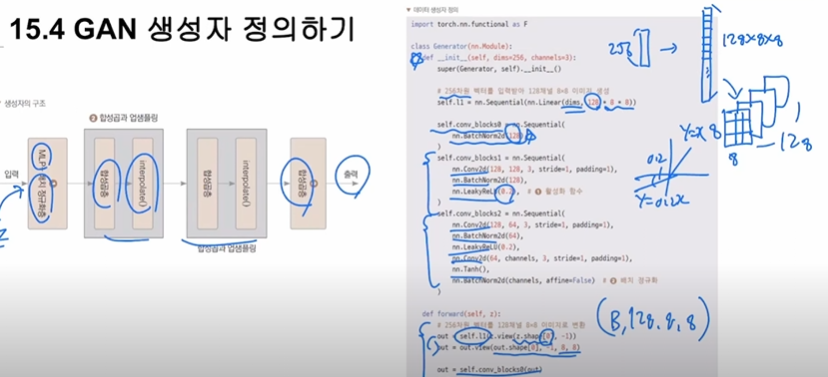

In [ ]:
import torch.nn.functional as F

class Generator(nn.Module):
   def __init__(self, dims=256, channels=3):
       super(Generator, self).__init__()

       # 256 차원 벡터를 입력받아 128채널 8X8 이미지 생성
       self.l1 = nn.Sequential(nn.Linear(dims, 128 * 8 * 8))

       self.conv_blocks0 = nn.Sequential(
           nn.BatchNorm2d(128),
       )
       self.conv_blocks1 = nn.Sequential(
           nn.Conv2d(128, 128, 3, stride=1, padding=1),
           nn.BatchNorm2d(128),
           nn.LeakyReLU(0.2),  # ① 활성화 함수
       )
       self.conv_blocks2 = nn.Sequential(
           nn.Conv2d(128, 64, 3, stride=1, padding=1),
           nn.BatchNorm2d(64),
           nn.LeakyReLU(0.2),
           nn.Conv2d(64, channels, 3, stride=1, padding=1),
           nn.Tanh(),
           nn.BatchNorm2d(channels, affine=False)  # ② 배치 정규화
       )

   def forward(self, z):
       # 256차원 벡터를 128채널 8X8 이미지로 변환
       out = self.l1(z.view(z.shape[0], -1))
       out = out.view(out.shape[0], -1, 8, 8)

       out = self.conv_blocks0(out)
       # ③ 이미지를 두 배로 늘려줌
       out = nn.functional.interpolate(out, scale_factor=2)
       out = self.conv_blocks1(out)
       out = nn.functional.interpolate(out, scale_factor=2)
       out = self.conv_blocks2(out)
       return out

# 학생모델과 생성자 학습

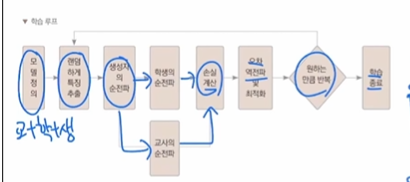

In [ ]:
from torch.optim.sgd import SGD

# ❶ 교사 모델 불러오기
teacher = resnet34(pretrained=False, num_classes=10)
teacher.load_state_dict(torch.load("./teahcer.pth", map_location=device))
teacher.to(device)
teacher.eval()

# ❷ 학생 모델 정의
student = resnet18(pretrained=False, num_classes=10)
student.to(device)

# ❸ 생성자 정의
generator = Generator()
generator.to(device)

# ❹ 생성자는 Adam으로, 학생 모델은 SGD를 이용해서 학습
G_optim = Adam(generator.parameters(), lr=1e-3)
S_optim = SGD(student.parameters(), lr=0.1, weight_decay=5e-4, momentum=0.9)

# 학습 루프 정의

In [ ]:
for epoch in range(500):
    # ⓵학생 모델을 5번, 생성자는 1번 가중치를 학습
    for _ in range(5):
        # ❶이미지 생성을 위한 노이즈 생성
        noise = torch.randn(256, 256, 1, 1, device=device)
        S_optim.zero_grad()
        # ❷이미지 생성
        fake = generator(noise).detach()
        # ❸교사의 예측
        teacher_output = teacher(fake)
        # ❹학생의 예측
        student_output = student(fake)
        # ❺학생의 오차 계산
        S_loss = nn.L1Loss()(student_output, teacher_output.detach())

        print(f"epoch{epoch}: S_loss {S_loss}")
        # ➏ 오차 역전파
        S_loss.backward()
        S_optim.step()
    # ➊ 이미지 생성을 위한 노이즈 정의
    noise = torch.randn(256, 256, 1, 1, device=device)
    G_optim.zero_grad()
    # ➋ 이미지 생성
    fake = generator(noise)

    # ➌ 교사와 학생 모델의 출력 계산
    teacher_output = teacher(fake)
    student_output = student(fake)

    # ➍ 생성자의 오차 계산
    G_loss = -1 * nn.L1Loss()(student_output, teacher_output)

    # ➎ 오차 역전파
    G_loss.backward()
    G_optim.step()

    print(f"epoch{epoch}: G_loss {G_loss}")

# 학생 모델 성능 평가하기

In [ ]:
num_corr = 0

student.load_state_dict(
    torch.load("./student.pth", map_location=device))

# 학습용 데이터에 대한 정확도
with torch.no_grad():
    for data, label in train_loader:

        output = student(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr

    print(f"Accuracy:{num_corr/len(training_data)}")

num_corr = 0

# 검증용 데이터에 대한 정확도
with torch.no_grad():
    for data, label in test_loader:

        output = student(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr

    print(f"Accuracy:{num_corr/len(test_data)}")